In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
tf.__version__

'1.13.1'

Load data

In [3]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [4]:
## Print some infor about MNIST data
print("Some number about MNIST data: ")
print("Number of train image: {}".format(data.num_train))
print("Number of validation image: {}".format(data.num_val))
print("Number of test image: {}".format(data.num_test))

Some number about MNIST data: 
Number of train image: 55000
Number of validation image: 5000
Number of test image: 10000


Copy some of data-dimension for convenience 

In [5]:
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes
print(img_size_flat)

784


Check 1 hot encoding

In [6]:
print("y_test: ")
print(data.y_test[0:9])
print("y_test_cls: ")
print(data.y_test_cls[0:9])

y_test: 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
y_test_cls: 
[7 2 1 0 4 1 4 9 5]


### Helper function for ploting image

In [7]:
def plot_images(images, true_labels, pred_labels = None):
    assert len(true_labels) == len(images) == 9
    
    # Create figure with 3x3 sub plot
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Set labels
        # Create labels
        if pred_labels is None:
            xlabel = "True: {0}".format(true_labels[i])
        else:
            xlabel = "True: {0} Predict: {1}".format(true_labels[i], pred_labels[i])
            
        # Set labels for plt
        ax.set_xlabel(xlabel)
        # Remove ticks 
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.show()        

/home/ubuntu/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


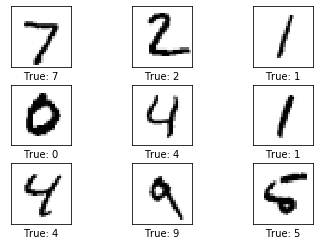

In [8]:
plot_images(data.x_test[0:9], data.y_test_cls[0:9])

### Declare Tensorflow graph variable

In [9]:
# Placeholder
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

In [10]:
# Variable
weight = tf.Variable(tf.zeros([img_size_flat, num_classes]))
bias = tf.Variable(tf.zeros([num_classes]))

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
# Model

logit = tf.matmul(x, weight) + bias

y_pred = tf.nn.softmax(logit)

y_pred_cls = tf.argmax(y_pred, axis=1)

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)
mean = tf.math.reduce_mean(cross_entropy)

optimize = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(mean)

In [23]:
correct_predict = tf.equal(y_pred_cls, y_true_cls)

accurancy = tf.reduce_mean(tf.cast(correct_predict, tf.float32))

### Declare Tensorflow session

In [24]:
session = tf.Session()

### Initialze variable

In [25]:
session.run(tf.global_variables_initializer())

### Helper function for perform optiminizetion ierations 

In [62]:
BATCH_SIZE = 100

def optimizer(n):
    for i in range(0, n):
        x_batch, y_batch, _ = data.random_batch(batch_size=BATCH_SIZE)
    
        feed_dict_train = {x: x_batch, 
                           y_true: y_batch}
        
        session.run(optimize, 
                    feed_dict=feed_dict_train)
    

### Helper function for plot the model weights


In [70]:
def plot_weights():
    w = session.run(weight)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < 10:
            ax.imshow(w[:, i].reshape(img_shape), vmin=w_min, vmax=w_max, cmap='seismic')
            xlabel = "Predict: {0}".format(i) 
            ax.set_xlabel(xlabel)
            
            # Remove sticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Helper function for show performance

In [47]:
# Create feed dict test
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}


In [48]:
# print accurancy
def print_accurancy():
    acc = session.run(accurancy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [74]:
# print confusion matrix 
def print_confusion_matrix():
    cls_true = data.y_test_cls
    cls_pred = session.run(y_pred_cls,
                           feed_dict=feed_dict_test)
    
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)

In [50]:
def plot_error_images():
    correct, cls_pred = session.run([conrrect_predict, y_pred_cls], 
                                    feed_dict=feed_dict_test)
    incorrect = (correct == False)
    
    img_incorrect = data.test_images[incorrect]
    true_labels = data.true_labels[incorrect]
    pred_labels = cls_pred[incorrect]
    
    plot_images(img_incorrect[0:9], true_labels[0:9], pred_labels[0:9])

### Performace without optimize

In [51]:
print_accurancy()

Accuracy on test-set: 9.8%


### Performce with 1 iterator

Accuracy on test-set: 58.0%


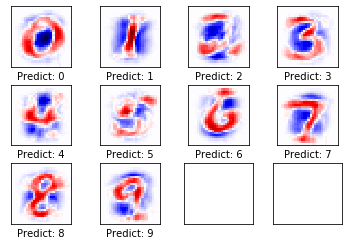

In [71]:
optimizer(1)
print_accurancy()
plot_weights()

### Performace with 10 iterators

Accuracy on test-set: 71.1%


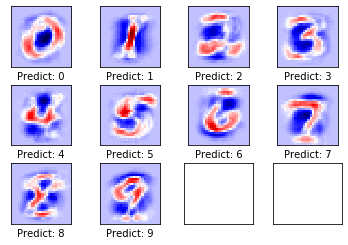

In [72]:
optimizer(9)
print_accurancy()
plot_weights()

### Performace with 1000 iterator

Accuracy on test-set: 91.9%


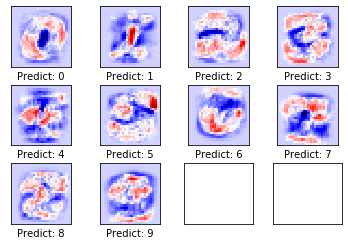

[[ 961    0    2    3    0    3    7    2    2    0]
 [   0 1108    4    2    0    1    3    2   15    0]
 [   6    8  931   18   10    1    7    8   36    7]
 [   2    1   24  942    0    6    1    8   19    7]
 [   3    3   10    2  887    0    8    3   10   56]
 [   9    2    7   70    9  722   11    9   44    9]
 [  13    3   11    2   10   12  901    2    4    0]
 [   3    9   29   10    5    1    0  931    4   36]
 [   4    8    7   32    8   16    8    5  880    6]
 [   9    8    2   12   20    5    0   18   10  925]]


In [75]:
optimizer(1000)
print_accurancy()
plot_weights()
print_confusion_matrix()